In [13]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [16]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)



In [18]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [19]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates


def calc_temps(trip_start_date, trip_end_date, most_recent_date):
    
    # Prepare date specifics  for selecting proper year for query
    m_yr = most_recent_date[0:4]
    m_md = str(most_recent_date[5:7]) + str(most_recent_date[8:10])
    if m_md[0:1] == "0":
        m_md = m_md[1:] # (MonthDay) eval will not work on a string starting with zero
        
    # Allow for updates to the data file to accomodate for same year conditions or older trip dates
    t_yr = trip_end_date[0:4]
    t_md = str(trip_end_date[5:7]) + str(trip_end_date[8:10])
    if t_md[0:1] == "0":
        t_md = t_md[1:]

    # Figure it out for the year adjustement     
    if (eval(t_yr) > eval(m_yr) and eval(m_md) >= eval(t_md)):
        yr_adjust = 0
    elif eval(t_yr) < eval(m_yr) and eval(t_md) <= eval(m_md):
        yr_adjust = 0
    else:
        yr_adjust = 1   
    
    # Build dates for past data per time frame - Get most recent year's data for the trip days
    #rec_date = str(most_recent_date)[2:-3]
    search_start_date = str(eval(most_recent_date[0:4])-yr_adjust) + trip_start_date[4:]
    search_end_date = str(eval(most_recent_date[0:4])-yr_adjust) + trip_end_date[4:]
    # existing code from supplied notebook: modified and cleaned up
    trip_stats = session.query(func.min(Measurement.tobs),
                               func.avg(Measurement.tobs),
                               func.max(Measurement.tobs))\
    .filter(Measurement.date >= search_start_date)\
    .filter(Measurement.date <= search_end_date).all()
    TMIN = trip_stats[0][0]
    TAVG = trip_stats[0][1]
    TMAX = trip_stats[0][2]
    
    return TMIN, TAVG, TMAX, search_start_date, search_end_date

In [33]:
# Calculate the date 1 year ago from today - re-posted here for reference
most_recent_date = session.query(Measurement.date)\
    .order_by(Measurement.date.desc()).first() 
most_recent_date = most_recent_date[0]

In [34]:
# Hard code trip dates in lieu of webside request

# RE_RUN this cell with sample dates below.  TEST results will print below cell

# The function is written to work with updated data as well
# All queryies will return the most recent year's data for the month/day time period

# --Will use 2016 data because there is no data after 2017-08-23 at the time of this code
start_date = "2018-11-10"
end_date = "2018-11-24"

# --Will use 2017 data
# start_date = "2018-01-10"
# end_date = "2018-01-24"

# --Will use 2016 data because there is no data after 2017-08-23 at the time of this code
# start_date = "2017-12-01"
# end_date = "2017-12-15"

# --Will use 2016 data because there is no data after 2017-08-23 at the time of this code
# start_date = "2011-11-10"
# end_date = "2011-11-24"

# Process dates for appropriate year's data query
TMIN, TAVG, TMAX, search_sd, search_ed = calc_temps(start_date, end_date, most_recent_date)
tmp_avg = "{0:.1f}".format(TAVG)

# Print RESULTS:
print()
print(f"Most recent termperature data available is up until:\n  {most_recent_date}")
print()
print(f"Trip Start and End dates:\n  {start_date}\n  {end_date}")
print(f"Calculated Search Dates based on Trip Ending Date:\n  {search_sd}\n  {search_ed}")
print(f"RESULTS:\n  Temp Min: {TMIN}  Temp Avg: {tmp_avg}  Temp: {TMAX}")


Most recent termperature data available is up until:
  2017-08-23

Trip Start and End dates:
  2018-11-10
  2018-11-24
Calculated Search Dates based on Trip Ending Date:
  2016-11-10
  2016-11-24
RESULTS:
  Temp Min: 67.0  Temp Avg: 74.8  Temp: 80.0


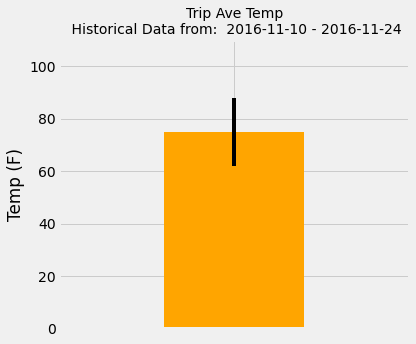

<Figure size 432x288 with 0 Axes>

In [35]:
plt.subplots(figsize=(6,5))
plt.xlim(0, 2)
plt.ylim([0,110])
plt.bar(1, TAVG, color = 'orange', yerr = TMAX-TMIN, tick_label="", align='center')
plt.title(f"Trip Ave Temp\n Historical Data from:  {search_sd} - {search_ed}", fontsize=14)
plt.ylabel("Temp (F)")
plt.tight_layout()

plt.show()
plt.savefig('trip_ave_temp.png')

### Daily Rainfall Average

In [37]:
q = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= search_sd)\
.filter(Measurement.date <= search_ed)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

# A nice layout to read the results
print()
print (f"Historical Rainfall Per Weather Station - Descending order\n  Trip Dates: \
{start_date} - {end_date}\n  Most Recent Data Search Dates: {search_sd} - {search_ed}")
print()
for row in q:
    rain="{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\n    Rainfall:  {rain}  \n    Location:  {row[2]}\n    Elevation:  {row[3]}  \
    Latitude:  {row[4]}  Longitude:  {row[5]}")
    print()       


Historical Rainfall Per Weather Station - Descending order
  Trip Dates: 2018-11-10 - 2018-11-24
  Most Recent Data Search Dates: 2016-11-10 - 2016-11-24

Station:  USC00516128
    Rainfall:  6.93  
    Location:  MANOA LYON ARBO 785.2, HI US
    Elevation:  152.4      Latitude:  21.3331  Longitude:  -157.8025

Station:  USC00519281
    Rainfall:  3.46  
    Location:  WAIHEE 837.5, HI US
    Elevation:  32.9      Latitude:  21.45167  Longitude:  -157.84888999999998

Station:  USC00519523
    Rainfall:  1.24  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Elevation:  19.5      Latitude:  21.33556  Longitude:  -157.71139

Station:  USC00513117
    Rainfall:  1.12  
    Location:  KANEOHE 838.1, HI US
    Elevation:  14.6      Latitude:  21.4234  Longitude:  -157.8015

Station:  USC00519397
    Rainfall:  0.41  
    Location:  WAIKIKI 717.2, HI US
    Elevation:  3.0      Latitude:  21.2716  Longitude:  -157.8168

Station:  USC00514830
    Rainfall:  0.23  
    Location:  KUALOA

In [ ]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates


# Strip off the year and save a list of strings in the format %m-%d


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session